![title](./img/bdeb-large-220x53.png)

---
#### Cours: 
420-A58-BB (Algorithmes d’apprentissage non supervisé)

#### Date:
Vendredi 26 novembre 2021

#### Enseignante :
Nathalie Jourdan, PhD

#### Groupe:
* Ricardo Vallejo
* Yulia Kalugina
* Emil Davila

#### Notation :
35%

---

# Projet de Session

## 1) Préparation

### Librairies

In [15]:
# Chargement des librairies
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.color as skimage_color
import skimage.io as skimage_io
from sklearn.cluster import KMeans

In [16]:
# Chargement des libraries additionnelles non liés au traitement principale (Déconvolution)
from IPython.display import Markdown, HTML, display
import math

In [17]:
# Verification des librairies installées
pd.show_versions()


INSTALLED VERSIONS
------------------
commit           : db08276bc116c438d3fdee492026f8223584c477
python           : 3.8.8.final.0
python-bits      : 64
OS               : Windows
OS-release       : 10
Version          : 10.0.19041
machine          : AMD64
processor        : Intel64 Family 6 Model 158 Stepping 10, GenuineIntel
byteorder        : little
LC_ALL           : None
LANG             : None
LOCALE           : English_Canada.1252

pandas           : 1.1.3
numpy            : 1.19.2
pytz             : 2020.1
dateutil         : 2.8.1
pip              : 21.3.1
setuptools       : 52.0.0.post20210125
Cython           : 0.29.22
pytest           : 6.2.2
hypothesis       : None
sphinx           : 3.5.1
blosc            : None
feather          : None
xlsxwriter       : 1.3.7
lxml.etree       : 4.5.2
html5lib         : 1.1
pymysql          : None
psycopg2         : None
jinja2           : 2.11.3
IPython          : 7.21.0
pandas_datareader: None
bs4              : 4.9.3
bottleneck       :

### Fonctions

In [18]:
# Fonction pour afficher du Markdown dans le code
def printmd(string):
    display(Markdown(string))

# Fonction pour afficher les dimensions d'un tableau ou dataframe
def show_shape(array_or_df, name):
    html = '<table><tr><th>Name</th><th>Type</th><th>Rows</th><th>Columns</th></tr><tr><td>{}</td><td>{}</td><td>{}</td><td>{}</td></tr></table>'.format(name,type(array_or_df).__name__,array_or_df.shape[0], array_or_df.shape[1])
    display(HTML(html))

# Fonction pour masquer l'image pour reconnaître les clusters identifiés
def masker(k, image, masks):
    fig, axs = plt.subplots(math.ceil(k/3), 3, figsize=(16,16), sharex=True, sharey=True, constrained_layout = False)
    image_copy = image.copy()
    for K in range(k):
        masked_image = np.dstack((image_copy[:, :, 0]*(masks==[K]),
                                  image_copy[:, :, 1]*(masks==[K]),
                                  image_copy[:, :, 2]*(masks==[K])))
        axs[K//3,K%3].imshow(masked_image)
        axs[K//3,K%3].set_title(f'Cluster : {K+1}', fontsize = 20)
        axs[K//3,K%3].set_axis_off();
    fig.tight_layout()

# Fonction pour charger une image en format RGB
def read_image_rgb(file='', library='skimage'):
    if file == '':
        print('Invalid library')
        quit()
    else:    
        if library == 'opencv':
            image = cv2.imread(file)
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        elif library == 'skimage':
            image_rgb = skimage_io.imread(file)
        else:
            print('Invalid library')
            quit()
    return image_rgb

# Fonction pour afficher une image en format RGB
def show_image_rgb(image_rgb, library='matplotlib', height=6, width=8, dpi=80):
    if library == 'matplotlib':
        plt.figure(num=None, figsize=(height, width), dpi=dpi)
        plt.imshow(image_rgb)
    elif library == 'skimage':
        skimage_io.imshow(image_rgb)
    else:
        print('Invalid library')
        quit()

# Fonction pour convertir une image de format RGB au format HSV
def convert_rgb2hsv(image_rgb):
    image_hsv = skimage_color.rgb2hsv(image_rgb)
    return image_hsv

# Fonction pour convertir une image RGB dans un tableau Numpy
def image_to_array(image_rgb):
    return np.float32(image_rgb.reshape((-1,3)))

# Fonction pour convertir une image RGB dans un dataframe pandas
def image_to_pandas(image):
    df = pd.DataFrame([image[:,:,0].flatten(),
                       image[:,:,1].flatten(),
                       image[:,:,2].flatten()]).T
    df.columns = ['Red','Green','Blue']
    return df

# Fonction pour évaluer l'impact de critères d'arrêt sur le résultat de l'algorithme KMeans
def evaluate_termination_criteria(Krange, Crange, image_rgb, image_rgb_array, termination_criteria, attempts, flags, height, width):
    _ = [None] * len(Krange)
    labels = [None] * len(Krange)
    centers = [None] * len(Krange)
    image_segmented_rgb = [[None for x in Crange] for y in Krange]
    for K in Krange:
        for C in Crange:
            _[K-2], labels[K-2], (centers[K-2]) = cv2.kmeans(image_rgb_array, K, None, termination_criteria[C], attempts, flags)
            # Convert back to a 8 bit values
            centers[K-2] = np.uint8(centers[K-2])
            # Flatten the labels array
            labels[K-2] = labels[K-2].flatten()
            # Convert all pixels to the color of the centroids
            image_segmented_rgb[K-2][C] = centers[K-2][labels[K-2].flatten()]
            # Reshape back to the original image dimension
            image_segmented_rgb[K-2][C] = image_segmented_rgb[K-2][C].reshape(image_rgb.shape)

    fig, axs = plt.subplots(len(Krange), len(Crange), figsize=(height,width), sharex=True, sharey=True, constrained_layout=True)
    for K in Krange:
        for C in Crange:
            axs[K-2,C].set_title('K = {} & C = {}'.format(K,C))
            axs[K-2,C].imshow(image_segmented_rgb[K-2][C])
    plt.suptitle('Impact des critères d\'arrêt sur l\'algorithme KMeans')
    plt.show()
    return image_segmented_rgb

# Fonction pour pour detecter la floraison dans l'image avec l'algorithme KMeans
def detect_flowers(Krange, Crange, image_rgb, image_rgb_array, termination_criteria, attempts, flags, height, width, img_per_line):
    _ = [None] * len(Krange)
    labels = [None] * len(Krange)
    centers = [None] * len(Krange)
    image_segmented_rgb = [[None for x in range(img_per_line)] for y in range(math.ceil(len(Krange)/img_per_line))]

    for K in Krange:
        _[K-Krange[0]], labels[K-Krange[0]], (centers[K-Krange[0]]) = cv2.kmeans(image_rgb_array, K, None, termination_criteria[0], attempts, flags)
        # Convert back to a 8 bit values
        centers[K-Krange[0]] = np.uint8(centers[K-Krange[0]])
        # Flatten the labels array
        labels[K-Krange[0]] = labels[K-Krange[0]].flatten()
        # Convert all pixels to the color of the centroids
        image_segmented_rgb[(K-Krange[0])//img_per_line][(K-Krange[0])%img_per_line] = centers[K-Krange[0]][labels[K-Krange[0]].flatten()]
        # Reshape back to the original image dimension
        image_segmented_rgb[(K-Krange[0])//img_per_line][(K-Krange[0])%img_per_line] = image_segmented_rgb[(K-Krange[0])//img_per_line][(K-Krange[0])%img_per_line].reshape(image_rgb.shape)

    fig, axs = plt.subplots(math.ceil(len(Krange)/img_per_line), img_per_line, figsize=(height,width), sharex=True, sharey=True, constrained_layout = True)
    for K in Krange:
        if math.ceil(len(Krange)/img_per_line) == 1:
            axs[(K-Krange[0])//img_per_line].set_title('K = {}'.format(K))
            axs[(K-Krange[0])//img_per_line].imshow(image_segmented_rgb[(K-Krange[0])//img_per_line][(K-Krange[0])%img_per_line])
        else:
            axs[(K-Krange[0])//img_per_line,(K-Krange[0])%img_per_line].set_title('K = {}'.format(K))
            axs[(K-Krange[0])//img_per_line,(K-Krange[0])%img_per_line].imshow(image_segmented_rgb[(K-Krange[0])//img_per_line][(K-Krange[0])%img_per_line])
    plt.suptitle('KMeans')
    plt.show()
    return image_segmented_rgb

# Fonction pour pour detecter la floraison dans l'image avec l'algorithme KMeans
def get_percent(k_labels, k_centers):
    k_percent=[]
    for i in range(len(k_centers)):
        k_perc=list(k_labels).count(i)/len(list(k_labels))
        k_percent.append(k_perc)
    html1 = '<table><tr><th>Cluster</th><th>Percentage</th></tr>'
    html2 = ''
    for i in range(len(k_centers)):
        html2 += '<tr><td>{}</td><td>{:.2f}</td></tr>'.format(i,k_percent[i]*100)
    html3 = '</table>'
    display(HTML(html1+html2+html3))
    return(k_percent)

# Fonction pour afficher une diagramme circulaire (Camembert)
def show_camembert(data, centers):
    plt.pie(data,colors=np.array(centers/255),labels=np.arange(len(centers)), normalize=False)
    plt.show()

### Variables d'environnement

In [19]:
%env OMP_NUM_THREADS=1

env: OMP_NUM_THREADS=1


## 2) Définition de l'objectif du projet

Identifier le pourcentage de l'image qui represente la floraison.

Avoir un algorithme capable de retrouver le pourcentage de floraison de l'image nous permettra de ramasser des statistiques sur l'évolution de la floraison tout au long de l'année.

## 3) Déconvolution d'image

### 3.1. Lecture de l'image

In [20]:
# Nom de fichier qui contient l'image à traiter en format JPEG 
v_image = './img/imageTravail.jpg'

#### Image en format RGB

In [21]:
# Charger l'image au format RGB
img_orig_rgb = read_image_rgb(v_image, 'opencv')

#### Image en format HSV

In [22]:
# Convertir l'image au format HSV
img_orig_hsv = convert_rgb2hsv(img_orig_rgb)

#### Récuperer les composants de couleur (RGB) de chaque pixel de l'image dans un TABLEAU NUMPY

In [23]:
# Convertir l'image dans un tableau 2D avec les 3 composantes de couleur(RGB)
img_orig_rgb_array =  image_to_array(img_orig_rgb)

In [24]:
# Afficher le nombre de lignes et colonnes du tableau
show_shape(img_orig_rgb_array,'img_orig_rgb_array')

Name,Type,Rows,Columns
img_orig_rgb_array,ndarray,1020800,3


#### Récuperer les composants de couleur (RGB) de chaque pixel de l'image dans un DATAFRAME PANDAS

In [25]:
# Convertir l'image à un dataframe pandas
img_orig_rgb_df = image_to_pandas(img_orig_rgb)

In [26]:
# Afficher le dataframe et ses dimensions
display(img_orig_rgb_df)

,Red,Green,Blue
0,206,217,237
1,206,217,237
2,206,217,237
3,206,217,237
4,206,217,237
...,...,...,...
1020795,156,131,91
1020796,163,138,97
1020797,164,139,98
1020798,172,149,107


#### Afficher l'image RGB

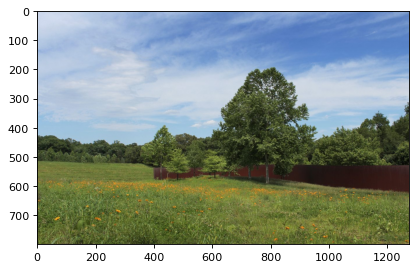

In [27]:
# Afficher l'image RGB (8x6 80dpi)
v_height=6
v_width=8
v_dpi=80
show_image_rgb(img_orig_rgb, 'matplotlib', v_height, v_width, v_dpi)

### 3.2. CRITÈRES D'ARRÊT pour la segmentation d'image avec K-means (OpenCV)

#### Définition des critères d\'arrêt

In [28]:
# Définition des critères d'arrêt
C = 3
Crange = list(range(0, C)) 
v_epsilon = 0.2
v_maxiter = 100
v_crit = [None] * len(Crange)

# crit[0] = EPS + MAX_ITER 
v_crit[0] = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, v_maxiter, v_epsilon)
# crit[1] = EPS
v_crit[1] = (cv2.TERM_CRITERIA_EPS, v_maxiter, v_epsilon)
# crit[2] = MAX_ITER
v_crit[2] = (cv2.TERM_CRITERIA_MAX_ITER, v_maxiter, v_epsilon)

#### Impact des critères d\'arrêt sur l\'algorithme KMeans

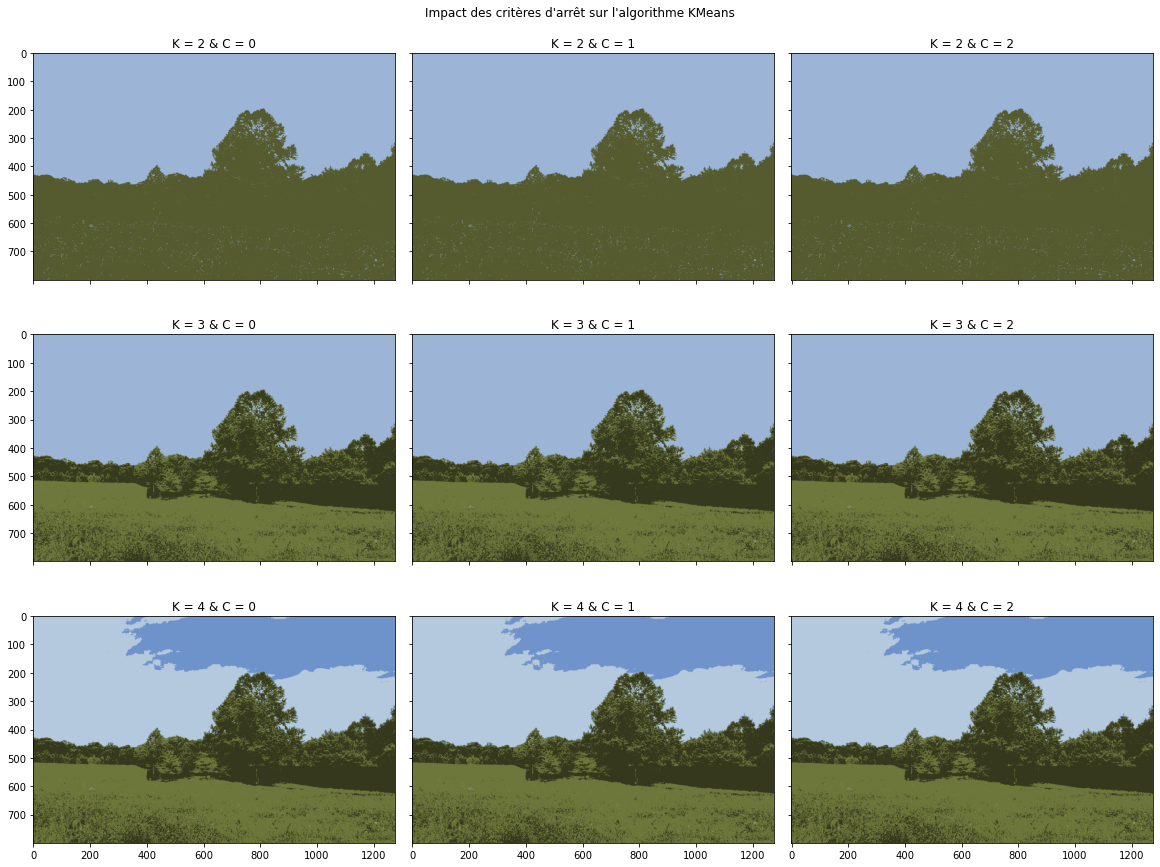

In [29]:
#######################
# Kmeans (K in [2-4]) #
#######################
# K = Number of clusters
# v_critN = Termination criteria
# v_attempts = Number of attempts
# v_flags = How initial centers are taken (KMEANS_PP_CENTERS or KMEANS_RANDOM_CENTERS)
# v_height = Height of the image
# v_width = Width of the image
Krange = list(range(2, 5)) 
v_attempts = 10
v_flags = cv2.KMEANS_RANDOM_CENTERS
v_height = 16
v_width = 12

img_segm_rgb = evaluate_termination_criteria(Krange,
                                             Crange,
                                             img_orig_rgb,
                                             img_orig_rgb_array,
                                             v_crit,
                                             v_attempts,
                                             v_flags,
                                             v_height,
                                             v_width)

> **Conclusions:**
> * L'impact des critères d\'arrêt sur l\'algorithme KMeans est négligeable.
> * On choisi le critère C=0 (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER) pour continuer notre recherche

### 3.3. Utilisation de l'algorithme KMeans pour detecter la floraison dans l'image

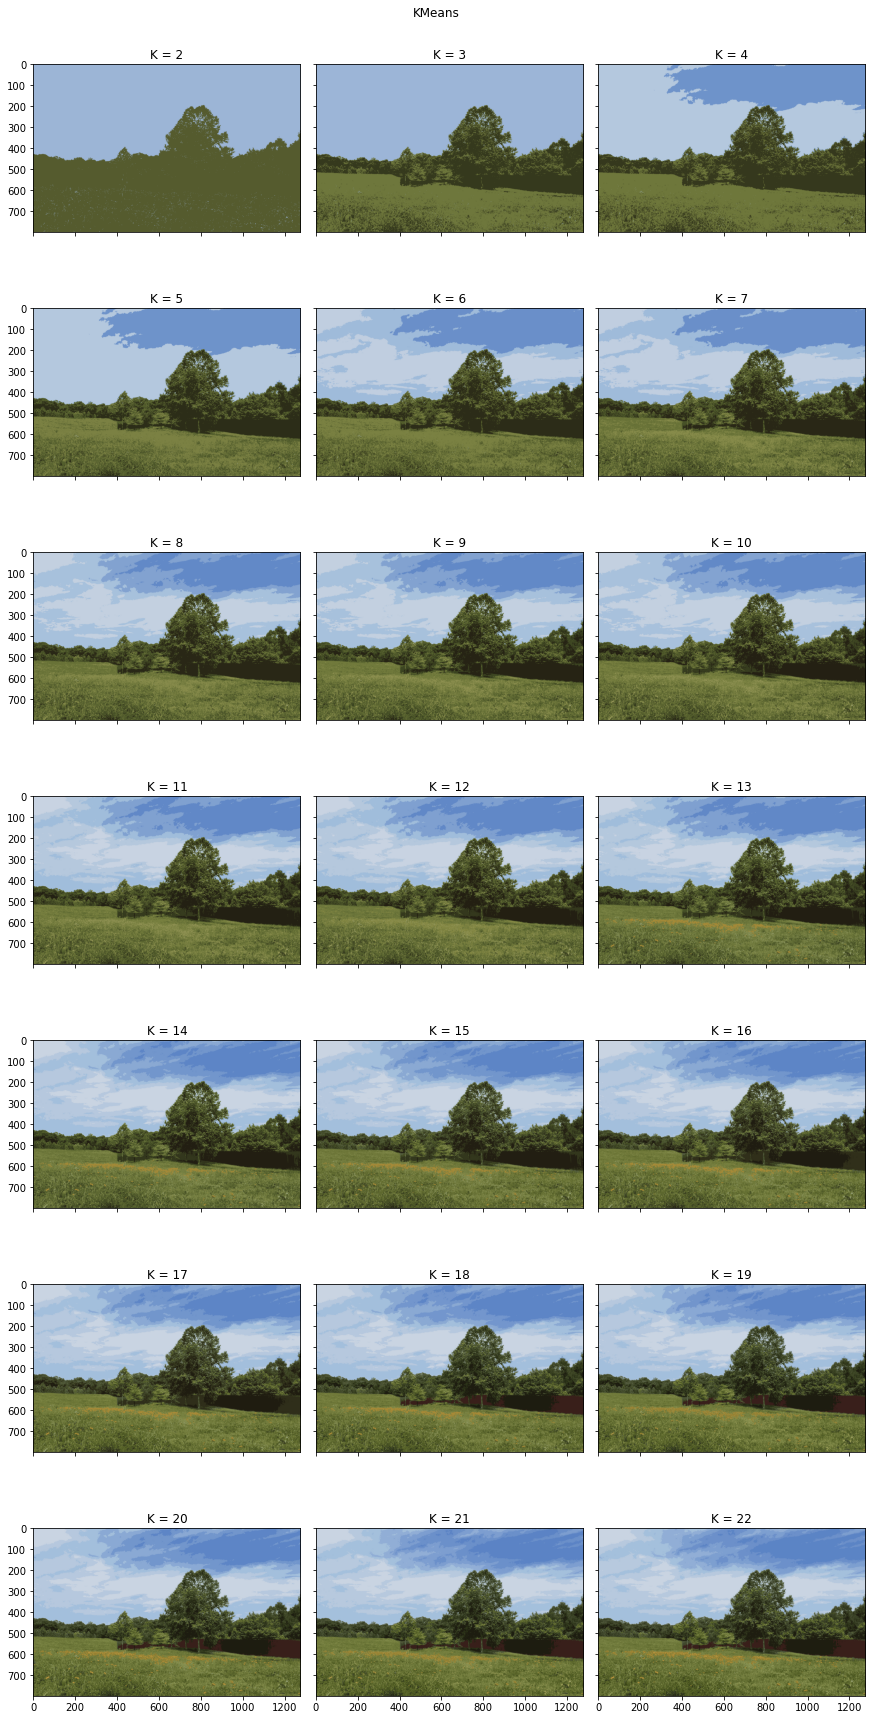

In [30]:
##########################
# Kmeans (K in [2 - 22]) #
##########################
# K = Number of clusters
# v_critN = Termination criteria
# v_attempts = Number of attempts
# v_flags = How initial centers are taken (KMEANS_PP_CENTERS or KMEANS_RANDOM_CENTERS)
# v_height = Height of the image
# v_width = Width of the image
# v_imgperline = number of images per line
Krange = list(range(2, 23))
v_attempts = 10
v_flags = cv2.KMEANS_PP_CENTERS
v_height = 12
v_width = 24
v_imgperline = 3

img_segm_rgb = detect_flowers(Krange,
                              Crange,
                              img_orig_rgb,
                              img_orig_rgb_array,
                              v_crit, v_attempts,
                              v_flags,
                              v_height,
                              v_width,
                              v_imgperline)

> **Conclusions:**
> * La floraison est detectée à partir de K=12.
> * On choisi K=13 pour les prochaines étapes

## 4) Approche 1:  Application de Kmeans avec K = 13 et utilisation de masques pour l'affichage des clusters

### 4.1. Utilisation de l'algorithme KMeans (K=13) pour detecter la floraison dans l'image

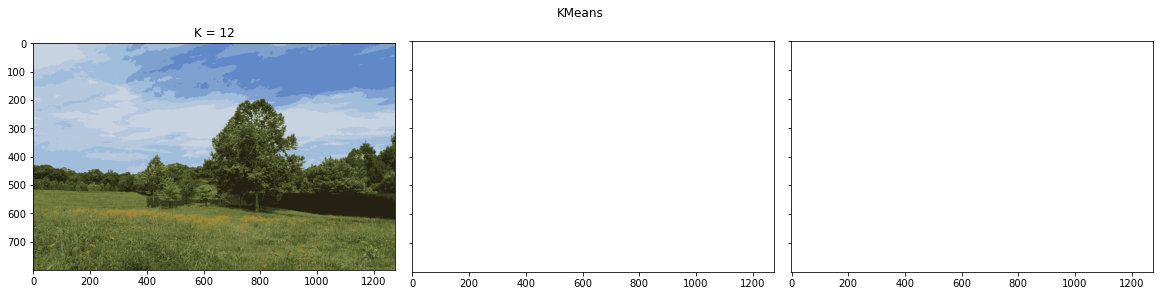

In [31]:
###################
# Kmeans (K = 13) #
###################
# K = Number of clusters
# v_critN = Termination criteria
# v_attempts = Number of attempts
# v_flags = How initial centers are taken (KMEANS_PP_CENTERS or KMEANS_RANDOM_CENTERS)
# v_height = Height of the image
# v_width = Width of the image
# v_imgperline = number of images per line
Krange = list(range(12, 13))
v_attempts = 10
v_flags = cv2.KMEANS_PP_CENTERS
v_height = 16
v_width = 4
v_imgperline = 3

img_segm_rgb = detect_flowers(Krange,
                              Crange,
                              img_orig_rgb,
                              img_orig_rgb_array,
                              v_crit,
                              v_attempts,
                              v_flags,
                              v_height,
                              v_width,
                              v_imgperline)

### 4.2. Utilisation de masques pour afficher les clusters identifiés

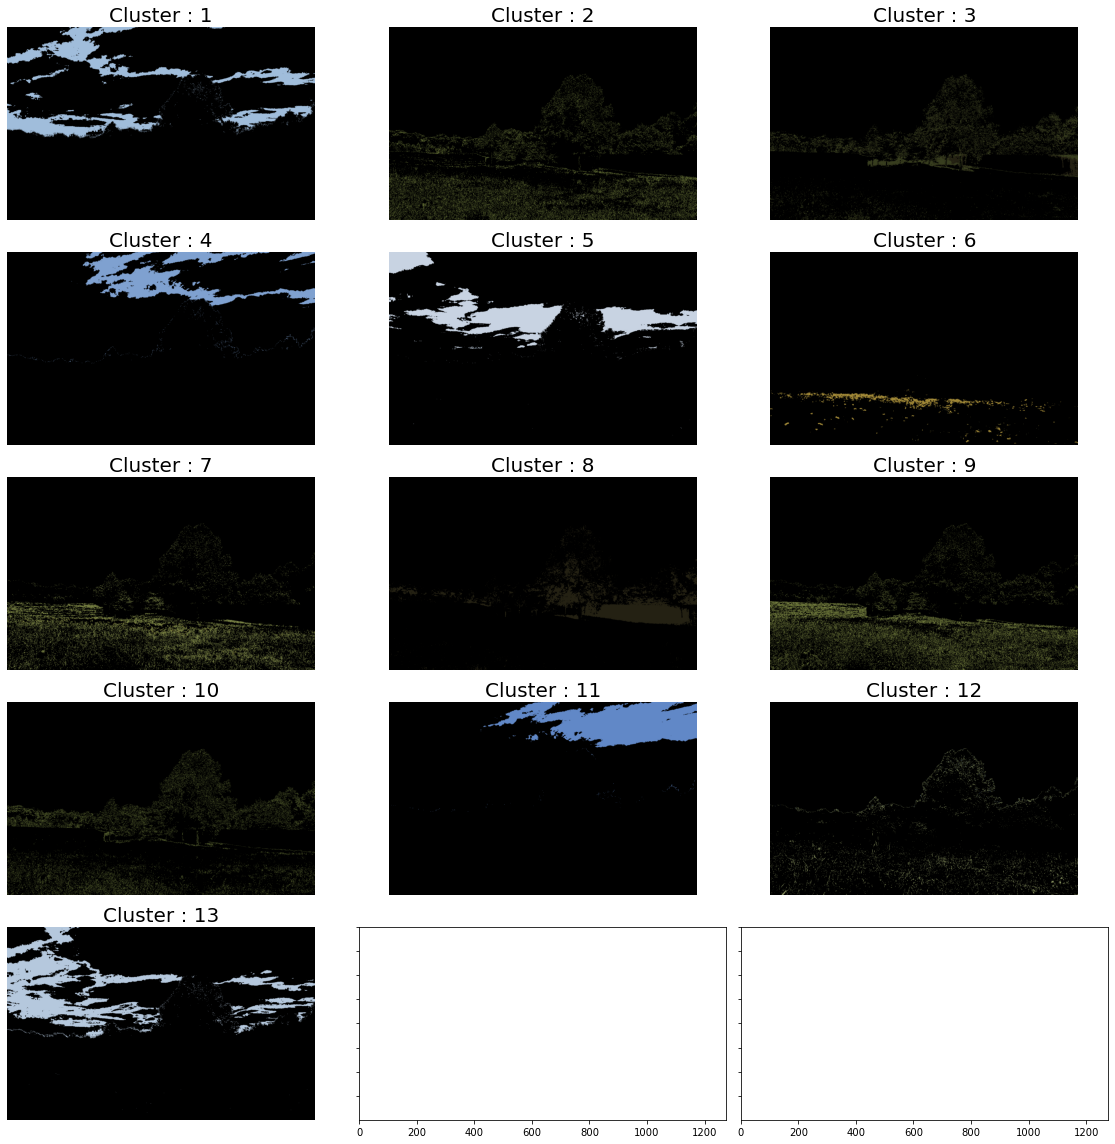

In [32]:
K = 13
v_attempts = 10
v_flags = cv2.KMEANS_PP_CENTERS

_Z, labelsZ, (centersZ) = cv2.kmeans(img_orig_rgb_array, K, None, v_crit[0], v_attempts, v_flags)
labelsZ = labelsZ.flatten()
filterZ = labelsZ.reshape(img_orig_rgb.shape[0],img_orig_rgb.shape[1])
masker(K,img_segm_rgb[0][0],filterZ)

> **Observation:**
> Le cluster 6 affiche la floraison dans l'image

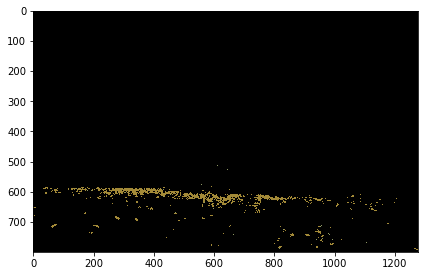

In [50]:
# Afficher seulement le cluster 6
N = 6
image_copy = img_segm_rgb[0][0].copy()
masked_image = np.dstack((image_copy[:, :, 0]*(filterZ==[N-1]), image_copy[:, :, 1]*(filterZ==[N-1]), image_copy[:, :, 2]*(filterZ==[N-1])))
skimage_io.imsave('./img/image1.jpg', masked_image)
skimage_io.imshow(masked_image)

> **Conclusion:**
> * Cluster choisi: 6
> * Le cluster 6 contient les pixels correspondant à la floraison dans l'image

### 4.3.  Pourcentage de l'image representé par la floraison

#### Affichage de façon tabulaire

In [34]:
# labels = Labels assigned to each cluster
# centers = Centroids

v_percent = get_percent(labelsZ, centersZ)

Cluster,Percentage
0,10.16
1,8.96
2,7.08
3,7.10
4,9.77
5,1.33
6,7.53
7,6.48
8,10.46
9,7.81


#### Affichage de façon graphique

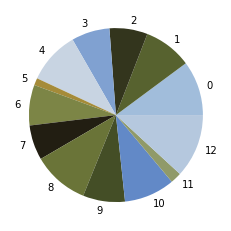

In [35]:
# Afficher un diagramme circulaire
show_camembert(v_percent, centersZ)

> **Conclusion:**
> * Le cluster 33 qui contient les pixels correspondant à la floraison  represente le 1.33% de l'image

##  5) Approche 2: Masquage pour elimination recurrent de clusters apres K-means

In [36]:
## read the image
image = cv2.imread("./img/imageTravail.jpg")
## convert to RGB
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

### 5.1. Diagrame de coude

In [37]:
img=image.reshape((image.shape[1]*image.shape[0],3))

In [38]:


md=[]
for i in range(1,11):
    kmeans=KMeans(n_clusters=i)
    kmeans.fit(img)
    o=kmeans.inertia_
    md.append(o)

print(md)

[13335775629.1449, 2711505503.925537, 1673829387.3357894, 776697008.536369, 565999362.4331741, 462614700.0391491, 376109001.47850424, 322061512.1076014, 276760885.34713393, 251382315.9658944]


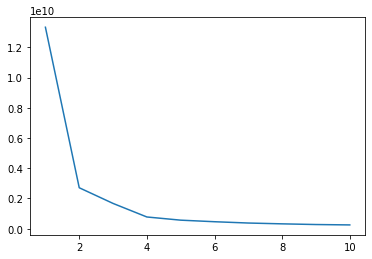

In [39]:
plt.plot(list(np.arange(1,11)),md)
plt.show()

### 5.2.  Kmeans avec k=4

In [53]:
## reshape the image to a 2D array of pixels and 3 color values (RGB)
pixel_values = image.reshape((-1, 3))
## convert to float
pixel_values = np.float32(pixel_values)

print(pixel_values.shape)

(1020800, 3)


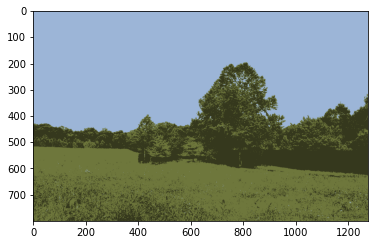

In [54]:
## define stopping criteria
n_iterations = 100
epsilon = 0.2
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, n_iterations, epsilon)

## number of clusters (K)
k = 3
_, labels, (centers) = cv2.kmeans(pixel_values, k, None, criteria, 10, cv2.KMEANS_PP_CENTERS)

## convert back to 8 bit values
centers = np.uint8(centers)

## flatten the labels array
labels = labels.flatten()

## convert all pixels to the color of the centroids
segmented_image = centers[labels.flatten()]

## reshape back to the original image dimension
segmented_image = segmented_image.reshape(image.shape)
## show the image
plt.imshow(segmented_image)
plt.show()

### 5.3. Masquage de clusters de ciel au image original

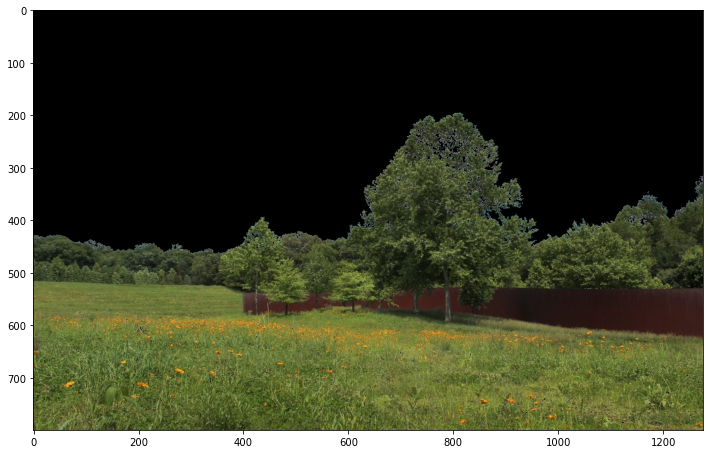

In [56]:
## disable only the cluster number 2 (turn the pixel into black)
masked_imageX = np.copy(image)
## convert to the shape of a vector of pixel values
masked_imageX = masked_imageX.reshape((-1, 3))
## color (i.e cluster) to disable
cluster = 1
masked_imageX[labels == cluster] = [0, 0, 0]
## convert back to original shape
masked_imageX = masked_imageX.reshape(image.shape)
## show the image
plt.figure(figsize=(12,12))
plt.imshow(masked_imageX)
plt.show()

### 5.4. Filtrage de clusters de fleurs.

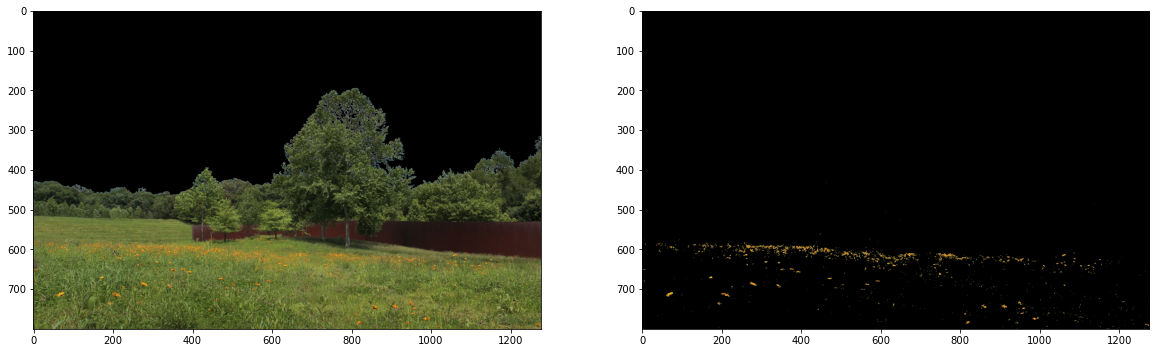

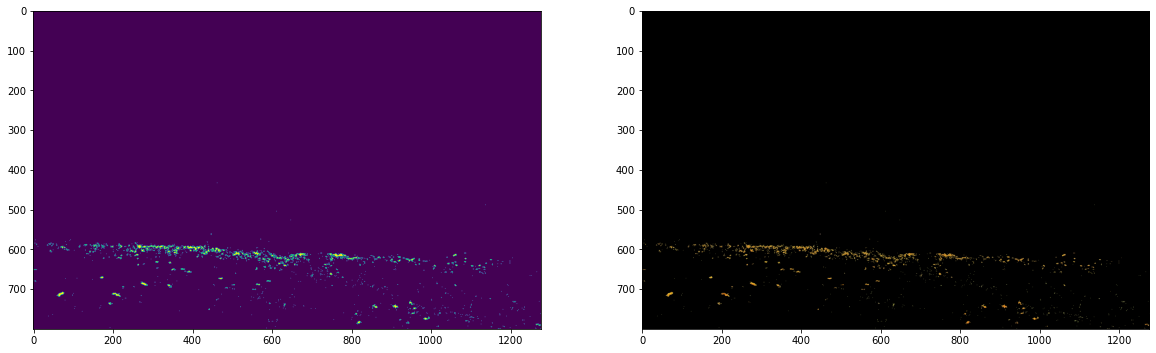

In [57]:
# Dans le domaine de HSV
# hsv_nemo = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

lower_limit = (166, 0, 0)
upper_limit = (255, 255, 255)

# Filter or Thresholding
mask = cv2.inRange(masked_imageX, lower_limit, upper_limit)

# Binary operations
result = cv2.bitwise_and(masked_imageX, masked_imageX, mask=mask)

plt.figure(figsize=(20,20))
plt.subplot(1, 2, 1)
plt.imshow(masked_imageX)
plt.subplot(1, 2, 2)
plt.imshow(result)
plt.imsave('./img/image2.jpg',result)
plt.show()


plt.figure(figsize=(20,20))
plt.subplot(1, 2, 1)
plt.imshow(mask)
plt.subplot(1, 2, 2)
plt.imshow(result)
plt.show()



### 5.5 Kmeans après Masquage 

In [58]:
from collections import Counter
from skimage.color import rgb2lab, deltaE_cie76

#Returns the colours in the image
def get_colours(img, no_of_colours, show_chart):
    
    #Reduce image size to reduce the execution time
    mod_img = cv2.resize(img, (600, 400), interpolation = cv2.INTER_AREA)
    #Reduce the input to two dimensions for KMeans
    mod_img = mod_img.reshape(mod_img.shape[0]*mod_img.shape[1], 3)

    #Define the clusters
    KmeansX = KMeans(n_clusters = no_of_colours)
    labels = KmeansX.fit_predict(mod_img)

    counts = Counter(labels)
    counts = dict(sorted(counts.items()))

    center_colours = KmeansX.cluster_centers_
    ordered_colours = [center_colours[i] for i in counts.keys()]
    hex_colours = [RGB2HEX(ordered_colours[i]) for i in counts.keys()]
    rgb_colours = [ordered_colours[i] for i in counts.keys()]

    return rgb_colours, KmeansX

    #Define the HEX values of colours
def RGB2HEX(color):
    return "#{:02x}{:02x}{:02x}".format(int(color[0]), int(color[1]), int(color[2]))



In [59]:
rgb_colours, KmeansX = get_colours(result, 2, True)

centroids = KmeansX.cluster_centers_
labels=  KmeansX.labels_

In [60]:
v_percent2 = get_percent(labels, centroids) 

Cluster,Percentage
0,99.33
1,0.67


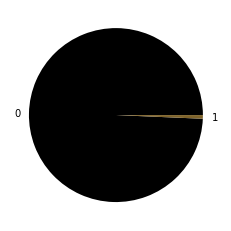

In [61]:
show_camembert(v_percent2,centroids)

# 6.  Resultats

#### Comparaison des resultats

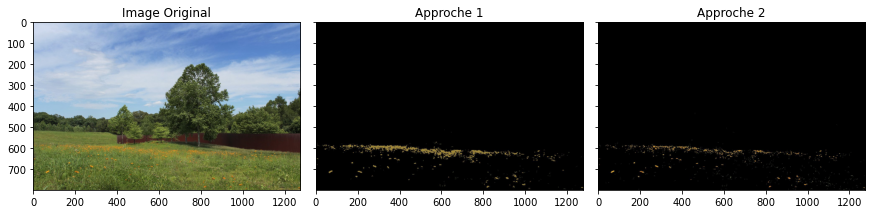

In [62]:
# Afficher l'image originale et le résultat de chaque approche
img_app01 = read_image_rgb('./img/image1.jpg', 'opencv')
img_app02 = read_image_rgb('./img/image2.jpg', 'opencv')
fig, axs = plt.subplots(1, 3, figsize=(12,9), sharex=True, sharey=True, constrained_layout=True)
axs[0].set_title('Image Original')
axs[1].set_title('Approche 1')
axs[2].set_title('Approche 2')
axs[0].imshow(img_orig_rgb)
axs[1].imshow(img_app01)
axs[2].imshow(img_app02)

Resultat 1,Resultat 2
1.33%,0.67%


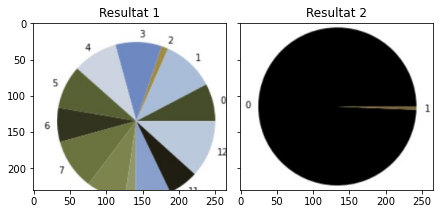

In [63]:
# Afficher le pourcentage trouvé par chaque approche
html = '<table><tr><th>Resultat 1</th><th>Resultat 2</th></tr><tr><td>1.33%</td><td>0.67%</td></tr></table>'
display(HTML(html))    
    
img_pie01 = read_image_rgb('./img/pie1.jpg', 'opencv')
img_pie02 = read_image_rgb('./img/pie2.jpg', 'opencv')
fig, axs = plt.subplots(1, 2, figsize=(6,6), sharex=True, sharey=True, constrained_layout=True)
axs[0].set_title('Resultat 1')
axs[1].set_title('Resultat 2')
axs[0].imshow(img_pie01)
axs[1].imshow(img_pie02)

#### Conclusions

>**Conclusions:**
>* C'est possible d'utiliser l'algorithme KMeans pour identifier la floraison dans l'image.
>* Le resultat peut être utilisé pour faire un suivi de la floraison dans le temps (Liste de images prises tout au long de l'année)
>* Une amélioration de la précisssion pourrait être nécessaire. À vérifier avec l'expert.
>* Plusieurs approches possibles.
>* L'implementation de l'algorithme KMeans de la librairie OpenCV a été utilisé dans le premier approche. Serait interessante d'utiliser d'autres implementations comme celui de sklearn et comparer les résultats obtenus.